Paxillin segmentation on zyxin data ( not the best data set to use)

Currently have three parts of duplicated code for the same analysis, trying to find a good way of appending the properties together

Will just keep the redundent code here, until no longer needed

Liya Ding 2024.02

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os.path
from tifffile import imread
from tifffile import imsave
from skimage.morphology import remove_small_objects    
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from scipy.ndimage import gaussian_filter
from joblib import dump, load

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [12]:
exp_list = ["TractionData_27_04_21_ZyxinPaxillin",'TractionData_21_07_27_ZyxinPaxillin']
exp_ID = exp_list[0]
print(exp_ID)

TractionData_27_04_21_ZyxinPaxillin


In [13]:
pny_dir =  '/mnt/d/lding/zyxin/data/data_pny_subset'
plot_output_dir = '/mnt/d/lding/zyxin/analysis/plot_output'
seg_output_dir = '/mnt/d/lding/zyxin/analysis/seg_output'


## Loading the data

In [20]:
exp_pny_dir = os.path.join(pny_dir, 'C467_'+exp_ID)

exp_plot_output_dir = os.path.join(plot_output_dir, exp_ID)
if not os.path.isdir(exp_plot_output_dir):
    os.makedirs(exp_plot_output_dir)

exp_seg_output_dir = os.path.join(seg_output_dir, exp_ID)
if not os.path.isdir(exp_seg_output_dir):
    os.makedirs(exp_seg_output_dir)

cellsubdirs = [x for x in os.listdir(exp_pny_dir) if os.path.isdir(os.path.join(exp_pny_dir, x)) and ('cell' in x)]

for cell_folder in cellsubdirs[0:1]:
    
    cell_image_path = os.path.join(exp_pny_dir,cell_folder)
    cell_plot_path = os.path.join(exp_plot_output_dir,cell_folder)
    cell_seg_path = os.path.join(exp_seg_output_dir,cell_folder)
    if not os.path.isdir(cell_plot_path):
        os.makedirs(cell_plot_path)
    if not os.path.isdir(cell_seg_path):
        os.makedirs(cell_seg_path)
    
    filenames = [x for x in os.listdir(cell_image_path) if os.path.isfile(os.path.join(cell_image_path, x)) and ('CellMask_Zyxin_PaxorActin_' in x)]

    for filename in filenames[0:1]:
        struct_img0 = np.load(os.path.join(cell_image_path,filename))

        org_mask = struct_img0[0,:,:]
        input_zyxin_img = struct_img0[1,:,:]
        input_pax_img = struct_img0[2,:,:]

        ### intensity normalization
        intensity_scaling_param = [5,20]
        norm_zyxin_img = intensity_normalization(input_zyxin_img, scaling_param=intensity_scaling_param)
        norm_pax_img = intensity_normalization(input_pax_img, scaling_param=intensity_scaling_param)

        # smoothing with edge preserving smoothing 
        smooth_zyxin_img = gaussian_filter(norm_zyxin_img,sigma=1,mode='nearest',truncate=3)
        smooth_pax_img = gaussian_filter(norm_pax_img,sigma=1,mode='nearest',truncate=3)

        new_cell_mask = smooth_zyxin_img>0.02
        new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=20, connectivity=1)

        ## PARAMETERS for vesselness filter step ##
        f2_param = [[1, 0.3]]
        pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)

        f2_param = [[1, 0.4]]
        zyxin_seg = filament_2d_wrapper(smooth_zyxin_img, f2_param)

        zyxin_seg = zyxin_seg*new_cell_mask
        zyxin_seg = remove_small_objects(zyxin_seg>0, min_size=2, connectivity=2)

        pax_seg = pax_seg*new_cell_mask
        pax_seg = remove_small_objects(pax_seg>0, min_size=2, connectivity=2)

        label_zyxin_seg = label(zyxin_seg*new_cell_mask)
        regionprops_zyxin = regionprops(label_zyxin_seg,input_zyxin_img)

        label_pax_seg = label(pax_seg*new_cell_mask)
        regionprops_pax = regionprops(label_pax_seg, input_pax_img)
        
        pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img*0, bg_label=0)
        zyxin_image_label_overlay = label2rgb(label_zyxin_seg, image=smooth_zyxin_img*0, bg_label=0)
        

        fig, ax = plt.subplots(2, 4, figsize=(8,4), dpi=144, facecolor='w', edgecolor='k')
        ax[0,0].imshow(input_zyxin_img, cmap=plt.cm.gray,vmax=400,vmin=0)
        ax[0,0].axis('off')
        ax[0,1].imshow(smooth_zyxin_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
        ax[0,1].axis('off')
        ax[0,2].imshow(zyxin_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
        ax[0,2].axis('off')
        ax[0,3].imshow(zyxin_image_label_overlay/(zyxin_image_label_overlay.max()))
        ax[0,3].axis('off')

        ax[1,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=150,vmin=0)
        ax[1,0].axis('off')
        ax[1,1].imshow(smooth_pax_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
        ax[1,1].axis('off')
        ax[1,2].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
        ax[1,2].axis('off')
        ax[1,3].imshow(pax_image_label_overlay/(pax_image_label_overlay.max()))
        ax[1,3].axis('off')

        plt.savefig(os.path.join(cell_plot_path,filename[:-4]+'org_sm_ves_seg.png'))
        
        imsave(os.path.join(cell_seg_path, 'zyxin_seg_'+filename[:-4] +'.tif'),zyxin_seg.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'pax_seg_'+filename[:-4] +'.tif'),pax_seg.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'zyxin_seglabel_'+filename[:-4] +'.tif'),label_zyxin_seg.astype(np.uint16))   
        imsave(os.path.join(cell_seg_path, 'pax_seglabel_'+filename[:-4] +'.tif'),label_pax_seg.astype(np.uint16))   
        imsave(os.path.join(cell_plot_path, 'zyxin_segrgb_'+filename[:-4] +'.tif'),zyxin_image_label_overlay.astype(np.uint8))   
        imsave(os.path.join(cell_plot_path, 'pax_segrgb_'+filename[:-4] +'.tif'),pax_image_label_overlay.astype(np.uint8))   
        
        dump('regionprops_pax',os.path.join(cell_seg_path, 'pax_regionpros_'+filename[:-4]))
        dump('regionprops_zyxin',os.path.join(cell_seg_path, 'zyxin_regionpros_'+filename[:-4]))

        plt.close(fig) 



In [15]:
# get the list of properties
supported = [] 
unsupported = []

for prop in regionprops_pax[0]:
    try:
        regionprops_pax[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))


Supported properties:
  area
  bbox
  bbox_area
  centroid
  convex_area
  convex_image
  coords
  eccentricity
  equivalent_diameter
  euler_number
  extent
  filled_area
  filled_image
  image
  inertia_tensor
  inertia_tensor_eigvals
  intensity_image
  label
  local_centroid
  major_axis_length
  max_intensity
  mean_intensity
  min_intensity
  minor_axis_length
  moments
  moments_central
  moments_hu
  moments_normalized
  orientation
  perimeter
  slice
  solidity
  weighted_centroid
  weighted_local_centroid
  weighted_moments
  weighted_moments_central
  weighted_moments_hu
  weighted_moments_normalized

Unsupported properties:
  


In [ ]:
exp_pny_dir = os.path.join(pny_dir, 'C467_'+exp_ID)

exp_plot_output_dir = os.path.join(plot_output_dir, exp_ID)
if not os.path.isdir(exp_plot_output_dir):
    os.makedirs(exp_plot_output_dir)

exp_seg_output_dir = os.path.join(seg_output_dir, exp_ID)
if not os.path.isdir(exp_seg_output_dir):
    os.makedirs(exp_seg_output_dir)

cellsubdirs = [x for x in os.listdir(exp_pny_dir) if os.path.isdir(os.path.join(exp_pny_dir, x)) and ('cell' in x)]

for cell_folder in cellsubdirs[0:1]:
    
    cell_image_path = os.path.join(exp_pny_dir,cell_folder)
    cell_plot_path = os.path.join(exp_plot_output_dir,cell_folder)
    cell_seg_path = os.path.join(exp_seg_output_dir,cell_folder)
    if not os.path.isdir(cell_plot_path):
        os.makedirs(cell_plot_path)
    if not os.path.isdir(cell_seg_path):
        os.makedirs(cell_seg_path)
    
    filenames = [x for x in os.listdir(cell_image_path) if os.path.isfile(os.path.join(cell_image_path, x)) and ('CellMask_Zyxin_PaxorActin_' in x)]

    for filename in filenames[0:1]:
        struct_img0 = np.load(os.path.join(cell_image_path,filename))

        org_mask = struct_img0[0,:,:]
        input_zyxin_img = struct_img0[1,:,:]
        input_pax_img = struct_img0[2,:,:]

        ### intensity normalization
        intensity_scaling_param = [5,20]
        norm_zyxin_img = intensity_normalization(input_zyxin_img, scaling_param=intensity_scaling_param)
        norm_pax_img = intensity_normalization(input_pax_img, scaling_param=intensity_scaling_param)

        # smoothing with edge preserving smoothing 
        smooth_zyxin_img = gaussian_filter(norm_zyxin_img,sigma=1,mode='nearest',truncate=3)
        smooth_pax_img = gaussian_filter(norm_pax_img,sigma=1,mode='nearest',truncate=3)

        new_cell_mask = smooth_zyxin_img>0.02
        new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=20, connectivity=1)

        ## PARAMETERS for vesselness filter step ##
        f2_param = [[1, 0.3]]
        pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)

        f2_param = [[1, 0.4]]
        zyxin_seg = filament_2d_wrapper(smooth_zyxin_img, f2_param)


        zyxin_seg = zyxin_seg*new_cell_mask
        pax_seg = pax_seg*new_cell_mask

        prop_list = ('area',
                    'area_bbox',
                    'area_convex',
                    'area_filled',
                    'axis_major_length',
                    'axis_minor_length',
                    'bbox',
                    'centroid',
                    'centroid_local',
                    'centroid_weighted',
                    'centroid_weighted_local',
                    'eccentricity',
                    'equivalent_diameter_area',
                    'euler_number',
                    'extent',
                    'feret_diameter_max',
                    'intensity_max',
                    'intensity_mean',
                    'intensity_min',
                    'labelint',
                    'moments_hu',
                    'num_pixels',
                    'orientation',
                    'perimeter',
                    'solidity')
        
        label_zyxin_seg = label(zyxin_seg*new_cell_mask)
        regionprops_zyxin = regionprops(label_zyxin_seg,input_zyxin_img)
        
        regionprops_zyxin_table = regionprops_table(label_zyxin_seg,intensity_image=input_zyxin_img)
                                                    # ,properties=('area','area_bbox','area_convex','area_filled','axis_major_length','axis_minor_length','bbox','centroid','centroid_local','centroid_weighted','centroid_weighted_local','eccentricity','equivalent_diameter_area','euler_number','extent','feret_diameter_max','intensity_max','intensity_mean','intensity_min','labelint','moments_hu','num_pixels','orientation','perimeter','solidity'))

        label_pax_seg = label(pax_seg*new_cell_mask)
        regionprops_pax = regionprops(label_pax_seg, input_pax_img)
        # regionprops_pax_table = regionprops_table(label_pax_seg,intensity_image=input_pax_img,properties=prop_list)
        
        pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img*0, bg_label=0)
        zyxin_image_label_overlay = label2rgb(label_zyxin_seg, image=smooth_zyxin_img*0, bg_label=0)
        

        fig, ax = plt.subplots(2, 4, figsize=(8,4), dpi=144, facecolor='w', edgecolor='k')
        ax[0,0].imshow(input_zyxin_img, cmap=plt.cm.gray,vmax=400,vmin=0)
        ax[0,0].axis('off')
        ax[0,1].imshow(smooth_zyxin_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
        ax[0,1].axis('off')
        ax[0,2].imshow(zyxin_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
        ax[0,2].axis('off')
        ax[0,3].imshow(zyxin_image_label_overlay/(zyxin_image_label_overlay.max()))
        ax[0,3].axis('off')

        ax[1,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=150,vmin=0)
        ax[1,0].axis('off')
        ax[1,1].imshow(smooth_pax_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
        ax[1,1].axis('off')
        ax[1,2].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
        ax[1,2].axis('off')
        ax[1,3].imshow(pax_image_label_overlay/(pax_image_label_overlay.max()))
        ax[1,3].axis('off')

        plt.savefig(os.path.join(cell_plot_path,filename[:-4]+'org_sm_ves_seg.png'))
        
        imsave(os.path.join(cell_seg_path, 'zyxin_seg_'+filename[:-4] +'.tif'),zyxin_seg.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'pax_seg_'+filename[:-4] +'.tif'),pax_seg.astype(np.uint8))   
        imsave(os.path.join(cell_seg_path, 'zyxin_seglabel_'+filename[:-4] +'.tif'),label_zyxin_seg.astype(np.uint16))   
        imsave(os.path.join(cell_seg_path, 'pax_seglabel_'+filename[:-4] +'.tif'),label_pax_seg.astype(np.uint16))   
        imsave(os.path.join(cell_plot_path, 'zyxin_segrgb_'+filename[:-4] +'.tif'),zyxin_image_label_overlay.astype(np.uint8))   
        imsave(os.path.join(cell_plot_path, 'pax_segrgb_'+filename[:-4] +'.tif'),pax_image_label_overlay.astype(np.uint8))   
        
        
        dump('regionprops_pax',os.path.join(cell_seg_path, 'pax_regionpros_'+filename[:-4]))
        dump('regionprops_zyxin',os.path.join(cell_seg_path, 'zyxin_regionpros_'+filename[:-4]))
        # data = load(data_filename_memmap, mmap_mode='r')

        plt.close(fig) 

        # fa_seg_plot(struct_img0, filename, cell_image_path, cell_plot_path, cell_seg_path)
        
        # print(struct_img0.shape)

        # fig, ax = plt.subplots(1, 3, figsize=(10,6), dpi=144, facecolor='w', edgecolor='k')
        # ax[0].imshow(struct_img0[0,:,:], cmap=plt.cm.gray,vmax=200,vmin=0)
        # ax[0].axis('off')
        # ax[1].imshow(struct_img0[1,:,:], cmap=plt.cm.gray,vmax=300,vmin=0)
        # ax[1].axis('off')
        # ax[2].imshow(struct_img0[2,:,:], cmap=plt.cm.gray,vmax=100,vmin=0)
        # ax[2].axis('off')


In [47]:
prop_df_zyxin = pd.DataFrame(columns=['cell_folder','time','label','area','eccentricity','perimeter','orientation','solidity'])
prop_df_pax = pd.DataFrame(columns=['cell_folder','time','label','area','eccentricity','perimeter','orientation','solidity'])

exp_pny_dir = os.path.join(pny_dir, 'C467_'+exp_ID)

exp_plot_output_dir = os.path.join(plot_output_dir, exp_ID)
if not os.path.isdir(exp_plot_output_dir):
    os.makedirs(exp_plot_output_dir)

exp_seg_output_dir = os.path.join(seg_output_dir, exp_ID)
if not os.path.isdir(exp_seg_output_dir):
    os.makedirs(exp_seg_output_dir)

cellsubdirs = [x for x in os.listdir(exp_pny_dir) if os.path.isdir(os.path.join(exp_pny_dir, x)) and ('cell' in x)]

for cell_folder in cellsubdirs:
    
    cell_image_path = os.path.join(exp_pny_dir,cell_folder)
    cell_plot_path = os.path.join(exp_plot_output_dir,cell_folder)
    cell_seg_path = os.path.join(exp_seg_output_dir,cell_folder)
    if not os.path.isdir(cell_plot_path):
        os.makedirs(cell_plot_path)
    if not os.path.isdir(cell_seg_path):
        os.makedirs(cell_seg_path)
    
    filenames = [x for x in os.listdir(cell_image_path) if os.path.isfile(os.path.join(cell_image_path, x)) and ('CellMask_Zyxin_PaxorActin_' in x)]

    for filename in filenames:
        struct_img0 = np.load(os.path.join(cell_image_path,filename))

        org_mask = struct_img0[0,:,:]
        input_zyxin_img = struct_img0[1,:,:]
        input_pax_img = struct_img0[2,:,:]

        ### intensity normalization
        intensity_scaling_param = [5,20]
        norm_zyxin_img = intensity_normalization(input_zyxin_img, scaling_param=intensity_scaling_param)
        norm_pax_img = intensity_normalization(input_pax_img, scaling_param=intensity_scaling_param)

        # smoothing with edge preserving smoothing 
        smooth_zyxin_img = gaussian_filter(norm_zyxin_img,sigma=1,mode='nearest',truncate=3)
        smooth_pax_img = gaussian_filter(norm_pax_img,sigma=1,mode='nearest',truncate=3)

        new_cell_mask = smooth_zyxin_img>0.02
        new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=20, connectivity=1, in_place=False)

        ## PARAMETERS for vesselness filter step ##
        f2_param = [[1, 0.3]]
        pax_seg = filament_2d_wrapper(smooth_pax_img, f2_param)

        f2_param = [[1, 0.4]]
        zyxin_seg = filament_2d_wrapper(smooth_zyxin_img, f2_param)


        zyxin_seg = zyxin_seg*new_cell_mask
        pax_seg = pax_seg*new_cell_mask
        
        
        label_zyxin_seg = label(zyxin_seg*new_cell_mask)
        regionprops_zyxin = regionprops(label_zyxin_seg)
        
        regionprops_zyxin_table = regionprops_table(label_zyxin_seg)
                                                    # ,properties=('area','area_bbox','area_convex','area_filled','axis_major_length','axis_minor_length','bbox','centroid','centroid_local','centroid_weighted','centroid_weighted_local','eccentricity','equivalent_diameter_area','euler_number','extent','feret_diameter_max','intensity_max','intensity_mean','intensity_min','labelint','moments_hu','num_pixels','orientation','perimeter','solidity'))

        label_pax_seg = label(pax_seg*new_cell_mask)
        regionprops_pax = regionprops(label_pax_seg)

        for iL in range(label_zyxin_seg.max()):
            s = pd.Series([float(cell_folder[-1]),float(filename[-7:-4]),regionprops_zyxin[iL].label,regionprops_zyxin[iL].area,regionprops_zyxin[iL].eccentricity,regionprops_zyxin[iL].perimeter,regionprops_zyxin[iL].orientation,regionprops_zyxin[iL].solidity],index=['cell_folder','time','label', 'area', 'eccentricity', 'perimeter', 'orientation', 'solidity'])
            prop_df_zyxin = prop_df_zyxin.append(s,ignore_index=True)
            # prop_df_zyxin.loc[len(prop_df_zyxin)] = pd.Series(dtype='float64')
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'cell_folder'] = float(cell_folder[-1])
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'time'] = float(filename[-7:-4])
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'label'] = iL
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'area'] = regionprops_zyxin[iL].area
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'eccentricity'] = regionprops_zyxin[iL].eccentricity
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'perimeter'] = regionprops_zyxin[iL].perimeter
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'orientation'] = regionprops_zyxin[iL].orientation
            # prop_df_zyxin.loc[len(prop_df_zyxin), 'solidity'] = regionprops_zyxin[iL].solidity
            
        for iL in range(label_pax_seg.max()):           
            s = pd.Series([float(cell_folder[-1]),float(filename[-7:-4]),regionprops_pax[iL].label,regionprops_pax[iL].area,regionprops_pax[iL].eccentricity,regionprops_pax[iL].perimeter,regionprops_pax[iL].orientation,regionprops_pax[iL].solidity],index=['cell_folder','time','label', 'area', 'eccentricity', 'perimeter', 'orientation', 'solidity'])
            prop_df_pax = prop_df_pax.append(s,ignore_index=True)
            # prop_df_pax.loc[len(prop_df_pax)] = pd.Series(dtype='float64')
            # prop_df_pax.loc[len(prop_df_pax), 'cell_folder'] = float(cell_folder[-1])
            # prop_df_pax.loc[len(prop_df_pax), 'time'] = float(filename[-7:-4])
            # prop_df_pax.loc[len(prop_df_pax), 'label'] = iL
            # prop_df_pax.loc[len(prop_df_pax), 'area'] = regionprops_pax[iL].area
            # prop_df_pax.loc[len(prop_df_pax), 'eccentricity'] = regionprops_pax[iL].eccentricity
            # prop_df_pax.loc[len(prop_df_pax), 'perimeter'] = regionprops_pax[iL].perimeter
            # prop_df_pax.loc[len(prop_df_pax), 'orientation'] = regionprops_pax[iL].orientation
            # prop_df_pax.loc[len(prop_df_pax), 'solidity'] = regionprops_pax[iL].solidity


       

/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/utils/utils.py:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]


RuntimeError: The data contains non-finite values.

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0496902978>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f04969028d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0496902e10>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0496919128>}

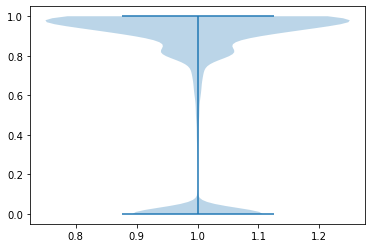

In [55]:
plt.violinplot(prop_df_pax.eccentricity)



{'bodies': [<matplotlib.collections.PolyCollection at 0x7f045c098a90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f045c0988d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f045c0982b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f045c0a0080>}

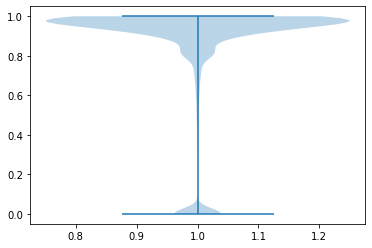

In [69]:
plt.violinplot(prop_df_zyxin.eccentricity)



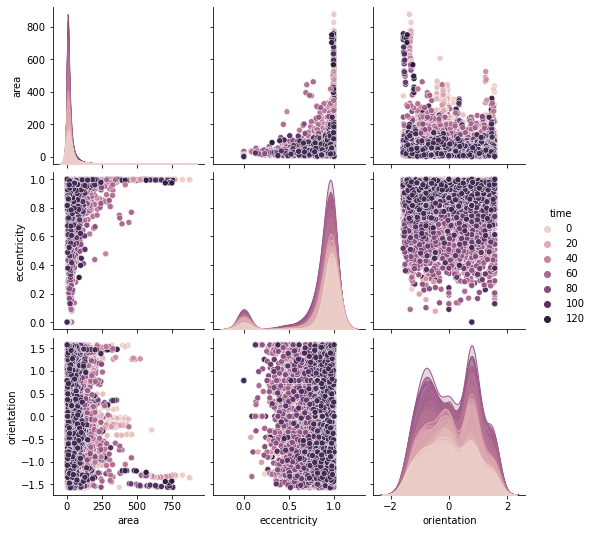

In [70]:
sns.pairplot(prop_df_zyxin[['area','eccentricity','orientation','time']], hue='time')

/home/lding/anaconda3/envs/aics_segmentation/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Text(0.5, 1.0, 'UMAP projection of the Zyxin dataset')

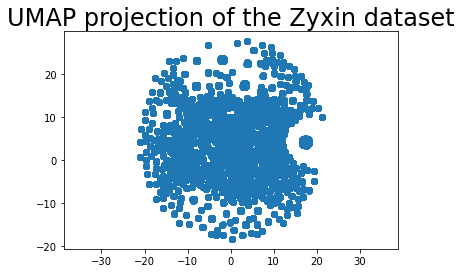

In [68]:
import umap

reducer = umap.UMAP()

prop_df_zyxin_data = prop_df_zyxin[    ['area','eccentricity','orientation' ,'perimeter','solidity'  ]].values

scaled_zyxin_data = StandardScaler().fit_transform(prop_df_zyxin_data)

reducer = umap.UMAP(random_state=42)
reducer.fit(prop_df_zyxin_data)

embedding = reducer.fit_transform(scaled_zyxin_data)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Zyxin dataset', fontsize=24)



{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0496690160>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f04966900b8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0496690630>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0496690908>}

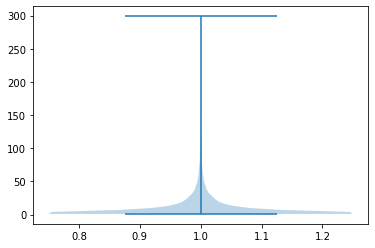

In [59]:
plt.violinplot(prop_df_pax.area[prop_df_pax.area<300])

In [ ]:
from skimage.color import label2rgb
pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img*0, bg_label=0)
zyxin_image_label_overlay = label2rgb(label_zyxin_seg, image=smooth_zyxin_img*0, bg_label=0)
# label_zyxin_seg[label_zyxin_seg==0]= np.nan

fig, ax = plt.subplots(2, 4, figsize=(8,4), dpi=144, facecolor='w', edgecolor='k')
ax[0,0].imshow(input_zyxin_img, cmap=plt.cm.gray,vmax=400,vmin=0)
ax[0,0].axis('off')
ax[0,1].imshow(smooth_zyxin_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
ax[0,1].axis('off')
ax[0,2].imshow(zyxin_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
ax[0,2].axis('off')
ax[0,3].imshow(zyxin_image_label_overlay/(zyxin_image_label_overlay.max()))
ax[0,3].axis('off')

ax[1,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=150,vmin=0)
ax[1,0].axis('off')
ax[1,1].imshow(smooth_pax_img, cmap=plt.cm.gray,vmax=0.3,vmin=0)
ax[1,1].axis('off')
ax[1,2].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
ax[1,2].axis('off')
ax[1,3].imshow(pax_image_label_overlay/(pax_image_label_overlay.max()))
ax[1,3].axis('off')

plt.savefig(os.path.join(plot_output_subdir,FILE_NAME[:-4]+'org_sm_ves_seg.png'))

